In [2]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

sns.set_theme(palette = 'cividis_r', style = 'ticks')
formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))

,Scan Rate (V/s),Ip C,Ip A,Up C,Up A,delta U
0,0.001,-0.000028,0.000027,3.991089,4.043579,0.052490
1,0.002,-0.000051,0.000051,3.970032,4.053040,0.083008
2,0.005,-0.000107,0.000110,3.939972,4.075470,0.135498
3,0.010,-0.000185,0.000186,3.908234,4.104767,0.196533
4,0.020,-0.000317,0.000313,3.863525,4.149170,0.285645


,D (cm/s) cathodic,D (cm/s) anodic
0,5.855460e-14,5.809361e-14


,b-value
0,0.771428


,b-value limited
0,0.921448


Text(0.5, 0, 'log Scan Rate')

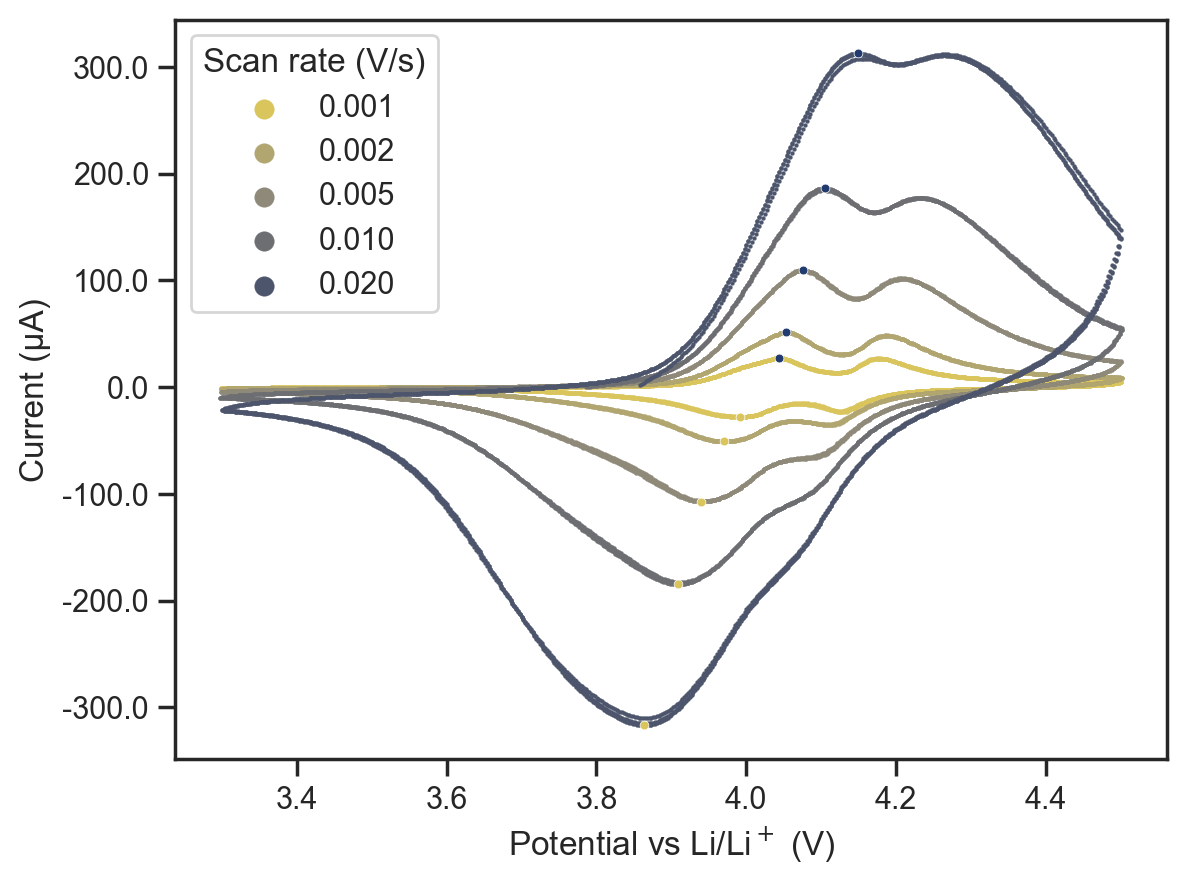

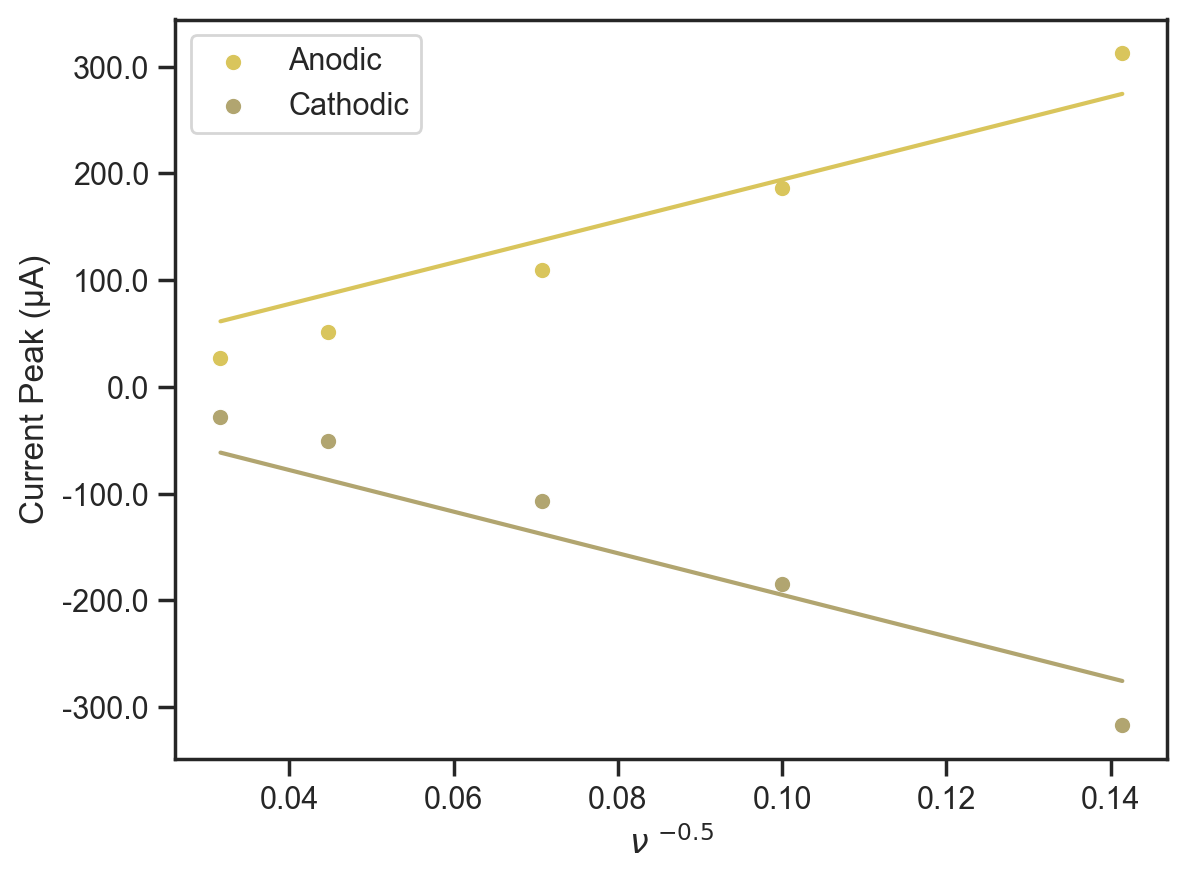

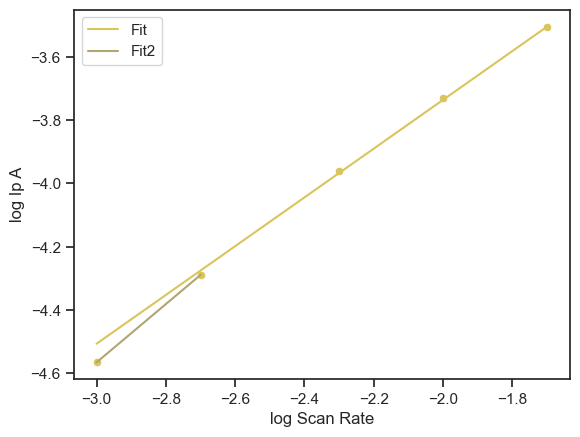

In [3]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LESK32\PLSA Pt\ScanRate'
files = [os.path.join(path, i) for i in os.listdir(path)]
col = ['Potential vs Li/Li$^+$ (V)', 'Current (A)', 'Charge (C)', 'Time (s)']
col2 = ['Current Peak (A)', 'Scan Rate (V/s)']
area = 0.785 # 7.85e-5 # m2 #
F = 96485.3321 # C / mol
R = 8.31446261815324 # J /(K * mol)
T = 300 #K
N = 1
C = 0.038297 # mol/cm3

def ran_sev(v, D): # C
    return 0.4463 * N * F * area * C * ((N * F * v * D) / (R * T))**0.5 # + a

def scan_rate_power_law(scanrate, a, b):
    return a * (scanrate ** b)

i_p_c = pd.DataFrame(columns = col2)
i_p_a = pd.DataFrame(columns = col2)

fig, ax = plt.subplots(dpi = 200)
scanrate_cvs = []
pk_currents = pd.DataFrame(columns=[col2[1], 'Ip C', 'Ip A','Up C','Up A', 'delta U'])

n = 0
for i in files:    
    
    df = pd.read_csv(i, sep = ';', names = col, skiprows=1)
    df['Scan Rate (V/s)'] = float(i[-13:-8])
    scanrate_cvs.append(df)
    current_peak_c = -min(df[col[1]])
    current_peak_a = max(df[col[1]])
    
    potential_c = df[col[0]][df['Current (A)'] == -current_peak_c].mean()
    potential_a = df[col[0]][df['Current (A)'] == current_peak_a].mean()
    delta_u = potential_a - potential_c
    pk_currents.loc[n] = (float(i[-13:-8]), -current_peak_c, current_peak_a, potential_c, potential_a, delta_u)
    
    i_p_c.loc[n] = (current_peak_c, float(i[-13:-8]))
    i_p_a.loc[n] = (current_peak_a, float(i[-13:-8])) 
    n += 1 
    sns.scatterplot(data = df, x = col[0], y = col[1], edgecolor = None, s = 2, label = i[-13:-8])

sns.scatterplot(x = pk_currents['Up A'], y = pk_currents['Ip A'], s = 10 )
sns.scatterplot(x = pk_currents['Up C'], y = pk_currents['Ip C'], s = 10 )

ax.legend(title = 'Scan rate (V/s)', markerscale = 5)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Current (µA)')

display(pk_currents)
    
################# Model fit
gmodel = Model(ran_sev)
params = gmodel.make_params()
params['D'].set(value = 1e-10, min = 1e-15, max = 1e-7)
# params['a'].set(value = 1)

gmodel2 = Model(scan_rate_power_law)
params2 = gmodel2.make_params()
params2['a'].set(value = 1)
params2['b'].set(value = 1)


########### Randles-sevick

result = gmodel.fit(i_p_c[col2[0]], params, v = i_p_c[col2[1]])
result_a = gmodel.fit(i_p_a[col2[0]], params, v = i_p_a[col2[1]])
rand_sev_result = pd.DataFrame({'D (cm/s) cathodic' : [result.params['D'].value],
                                'D (cm/s) anodic' : [result_a.params['D'].value]})
# print(result.fit_report())
# print(result_a.fit_report())
display(rand_sev_result)


########### Power law

result2 = gmodel2.fit(pk_currents['Ip A'], params2, scanrate = pk_currents['Scan Rate (V/s)'])
b_value = result2.params['b'].value
# print(result2.fit_report())
powerlaw_result = pd.DataFrame({'b-value' : [b_value]})
display(powerlaw_result)

### Only 'lim' number of points
lim = 2
result22 = gmodel2.fit(pk_currents['Ip A'][:lim], params2, scanrate = pk_currents['Scan Rate (V/s)'][:lim])
b_value22 = result22.params['b'].value
# print(result22.fit_report())
powerlaw_result = pd.DataFrame({'b-value limited' : [b_value22]})
display(powerlaw_result)

###### Plots

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(x = np.sqrt(i_p_a[col2[1]]), y = i_p_a[col2[0]], label = 'Anodic')
sns.scatterplot(x = np.sqrt(i_p_c[col2[1]]), y = -i_p_c[col2[0]], label = 'Cathodic')

plt.plot(np.sqrt(i_p_a[col2[1]]), result_a.best_fit)
plt.plot(np.sqrt(i_p_c[col2[1]]), -result.best_fit)

ax.set_ylabel('Current Peak (µA)')
ax.set_xlabel(r'$\nu$ $^{-0.5}$')
ax.yaxis.set_major_formatter(formatter)

# ax.set_xlabel(r'$i$ $\nu$ $^{-0.5}$')

fig, ax = plt.subplots()
sns.scatterplot(x = np.log10(pk_currents[col2[1]]), y = np.log10(pk_currents['Ip A']))
sns.lineplot(x = np.log10(pk_currents[col2[1]]), y = np.log10(result2.best_fit), label = 'Fit')
sns.lineplot(x = np.log10(pk_currents[col2[1]][:lim]), y = np.log10(result22.best_fit), label = 'Fit2')

ax.set_ylabel('log Ip A')
ax.set_xlabel('log Scan Rate')

In [4]:
################ Current Component

def current_components(scanrate, k1, k2):
    return (k1 * scanrate) + (k2 * (scanrate ** 0.5))

def lin_curr_comp(sqrt_scan_rate, k1, k2):
    return k1 * sqrt_scan_rate + k2 # i = k1v + k2 v**0.5 ==> i//v**0.5 = k1/v**0.5 + k2

gmodel3 = Model(current_components)
params3 = gmodel3.make_params()
params3['k1'].set(value = 1e-6)
params3['k2'].set(value = 1)

gmodel4 = Model(lin_curr_comp)
params4 = gmodel4.make_params()
params4['k1'].set(value = 1e-5)
params4['k2'].set(value = 1)



Text(0.5, 0.98, 'b-values')

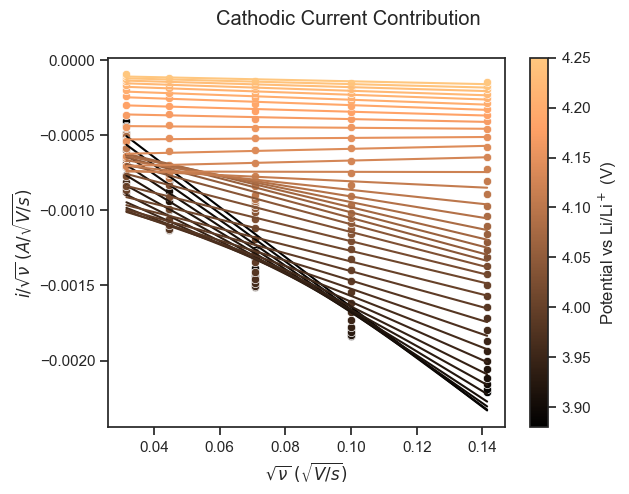

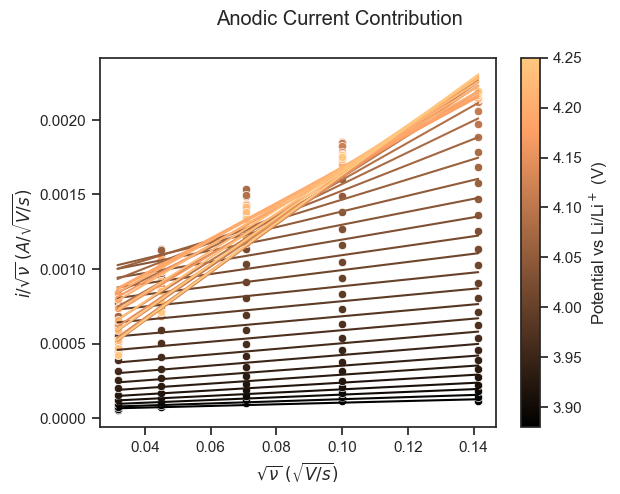

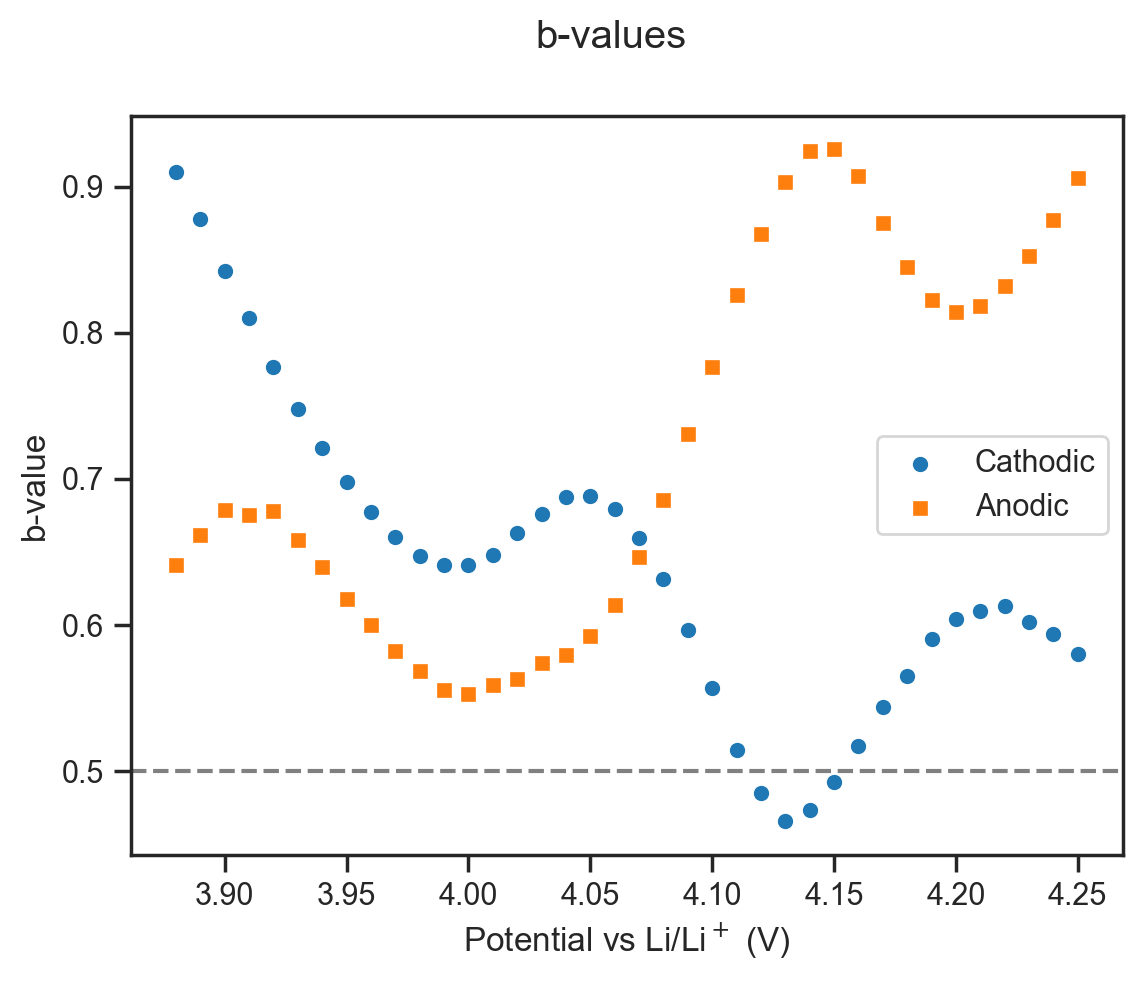

In [14]:

##################################################################################################################################

import warnings

# Turn off UserWarnings
warnings.simplefilter("ignore", category=UserWarning)


#####################################################################################################################################

potentials = np.arange(3.880, 4.250, 0.01)
h = 5 # Number of scan rates used
z = len(potentials)
cath_df = pd.DataFrame()
anod_df = pd.DataFrame()
all_df = pd.DataFrame()

for ex in scanrate_cvs:
    for pot in potentials:
        lim = 0.01
        high = round(pot + lim, 5) 
        low = round(pot - lim, 5)
        avg_rows_cath = ex[ex[col[0]] < high][ex[col[0]] > low][ex[col[1]] < 0].mean().to_frame().transpose()
        avg_rows_cath[col[0]] = avg_rows_cath[col[0]].round(3) 
        avg_rows_anod = ex[ex[col[0]] < high][ex[col[0]] > low][ex[col[1]] > 0].mean().to_frame().transpose() 
        avg_rows_anod[col[0]] = avg_rows_anod[col[0]].round(3)  
        cath_df = pd.concat([cath_df, avg_rows_cath], ignore_index=True)
        anod_df = pd.concat([anod_df, avg_rows_anod], ignore_index=True)

# # # Slice the DataFrame every 'h' rows
slices_cath = [cath_df.iloc[i:i+z] for i in range(0, len(cath_df), z)]
slices_anod = [anod_df.iloc[i:i+z] for i in range(0, len(anod_df), z)]

# Sort DataFrame cathodic by potentials and slice 'h' rows
sorted_cath = cath_df.sort_values(by = col[0], ignore_index = True)
sorted__anod = anod_df.sort_values(by = col[0], ignore_index = True)
sort_slices_cath = [sorted_cath.iloc[i:i+h] for i in range(0, len(sorted_cath), h)]
sort_slices_anod = [sorted__anod.iloc[i:i+h] for i in range(0, len(sorted__anod), h)]
contrib_cath = pd.DataFrame()
contrib_cath2 = pd.DataFrame()
contrib_anod2 = pd.DataFrame()

map = 'copper'
sns.set_palette(map, n_colors=len(potentials))
norm = Normalize(vmin=min(potentials), vmax=max(potentials))
cmap = matplotlib.colormaps[map]
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig, ax = plt.subplots(dpi = 100)

for i, slice_df in enumerate(sort_slices_cath):

    dfslice = slice_df.sort_values(by = col2[1], ignore_index = True)
    potential = dfslice[col[0]]
    current = dfslice[col[1]]
    scan_rate = dfslice[col2[1]]
    y = current / (scan_rate ** 0.5)
    x = scan_rate ** 0.5
    # fit = gmodel3.fit(current, params3, scanrate = x)
    # k1 = fit.params['k1'].value
    # k2 = fit.params['k2'].value
    # values = pd.DataFrame({col[0] : [round(dfslice[col[0]].mean(),2)],
    #                        'k1' : k1,
    #                        'k2' : k2} )
    # contrib_cath = pd.concat([contrib_cath, values], ignore_index = True)
    fit0 = gmodel2.fit(current, params2, scanrate = scan_rate)
    b_value = fit0.params['b'].value
    
    fit2 = gmodel4.fit(y, params4, sqrt_scan_rate = x)
    k1_ = fit2.params['k1'].value
    k2_ = fit2.params['k2'].value
    values2 = pd.DataFrame({col[0] : [round(dfslice[col[0]].mean(),2)],
                           'k1' : k1_,
                           'k2' : k2_,
                           'b-value' : b_value} )
    contrib_cath2 = pd.concat([contrib_cath2, values2], ignore_index = True)
    # sns.scatterplot(x = np.sqrt(scan_rate), y = current/np.sqrt(scan_rate), label = str(potential.mean().round(2)), s = 100)
    # sns.lineplot(x = np.sqrt(scan_rate), y = fit.best_fit/np.sqrt(scan_rate))
    color = sm.to_rgba(potential.mean().round(2))
    sns.scatterplot(x = x, y = y, color = color) #, label = str(potential.mean().round(2)))
    sns.lineplot(x = x, y = fit2.best_fit, color = color)

cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label= col[0])
ax.set_xlabel(r'$\sqrt{\nu}}$ $(\sqrt{V/s})$')
ax.set_ylabel(r'$i/\sqrt{\nu}$ $(A/\sqrt{V/s})$')
fig.suptitle('Cathodic Current Contribution')

fig, ax = plt.subplots(dpi = 100)
for i, slice_df in enumerate(sort_slices_anod):

    dfslice = slice_df.sort_values(by = col2[1], ignore_index = True)
    potential = dfslice[col[0]]
    current = dfslice[col[1]]
    scan_rate = dfslice[col2[1]]
    y = current / (scan_rate ** 0.5)
    x = scan_rate ** 0.5    
    fit0 = gmodel2.fit(current, params2, scanrate = scan_rate)
    b_value = fit0.params['b'].value
    fit2 = gmodel4.fit(y, params4, sqrt_scan_rate = x)
    k1_ = fit2.params['k1'].value
    k2_ = fit2.params['k2'].value
    values2 = pd.DataFrame({col[0] : [round(dfslice[col[0]].mean(),2)],
                           'k1' : k1_,
                           'k2' : k2_,
                           'b-value' : b_value} )
    contrib_anod2 = pd.concat([contrib_anod2, values2], ignore_index = True)

    color = sm.to_rgba(potential.mean().round(2))
    sns.scatterplot(x = x, y = y, color = color)
    sns.lineplot(x = x, y = fit2.best_fit, color = color)
    
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label= col[0])
ax.set_xlabel(r'$\sqrt{\nu}}$ $(\sqrt{V/s})$')
ax.set_ylabel(r'$i/\sqrt{\nu}$ $(A/\sqrt{V/s})$')
fig.suptitle('Anodic Current Contribution')

# sns.set_palette('viridis', n_colors=len(potentials))
fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = contrib_cath2, x = col[0], y = 'b-value', label = 'Cathodic', color = 'tab:blue')
sns.scatterplot(data = contrib_anod2, x = col[0], y = 'b-value', label = 'Anodic', color = 'tab:orange', marker = 's')
ax.axhline(y = 0.5, color = 'gray', linestyle = '--')
fig.suptitle('b-values')

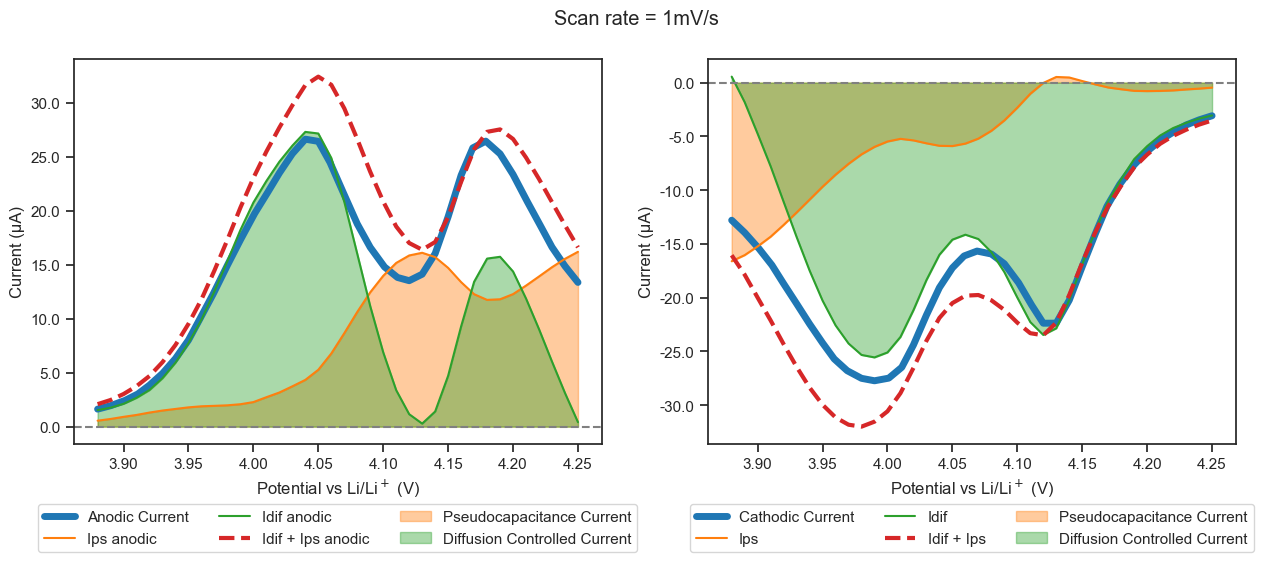

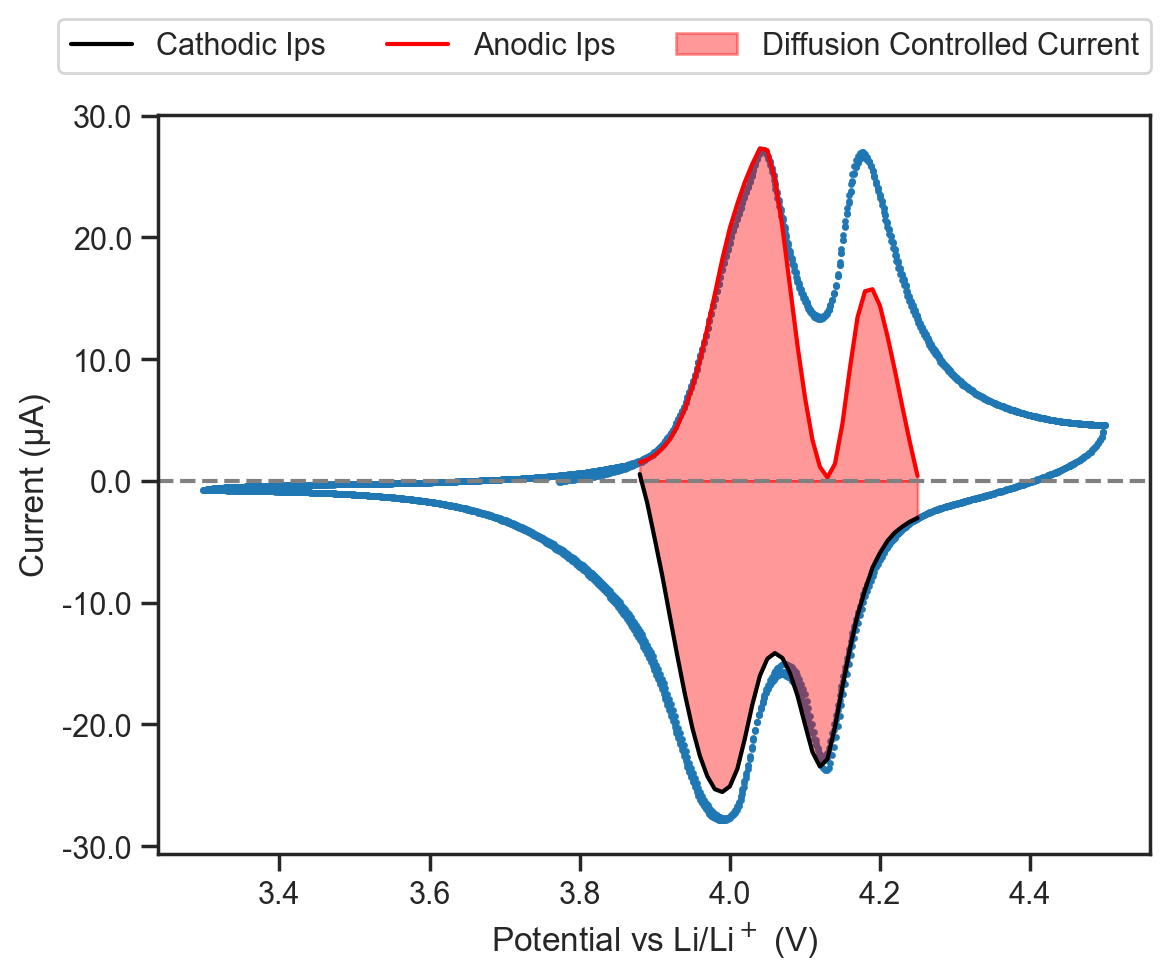

In [6]:
# contrib_cath['Ips (A)'] = contrib_cath['k1'] * 0.001
# contrib_cath['Idif (A)'] = contrib_cath['k2'] * (0.001**0.5)

contrib_cath2['Ips (A)'] = contrib_cath2['k1'] * 0.001
contrib_cath2['Idif (A)'] = contrib_cath2['k2'] * (0.001**0.5)
contrib_cath2['Idif + Ips (A)'] = contrib_cath2['Ips (A)'] + contrib_cath2['Idif (A)']

contrib_anod2['Ips (A)'] = contrib_anod2['k1'] * 0.001
contrib_anod2['Idif (A)'] = contrib_anod2['k2'] * (0.001**0.5)
contrib_anod2['Idif + Ips (A)'] = contrib_anod2['Ips (A)'] + contrib_anod2['Idif (A)']

# display(contrib_cath2)
# display(contrib_anod2)

# ### Plot
sns.set_palette('tab10')

fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 100)
ax[1].plot(slices_cath[0][col[0]], slices_cath[0][col[1]], label = 'Cathodic Current', lw = 5)
ax[0].plot(slices_anod[0][col[0]], slices_anod[0][col[1]], label = 'Anodic Current', lw = 5)

ax[1].plot(contrib_cath2[col[0]], contrib_cath2['Ips (A)'], label = 'Ips')
ax[1].plot(contrib_cath2[col[0]], contrib_cath2['Idif (A)'], label = 'Idif')
ax[1].plot(contrib_cath2[col[0]], contrib_cath2['Idif + Ips (A)'], label = 'Idif + Ips', lw = 3, linestyle = '--' )
ax[1].fill_between(contrib_cath2[col[0]], contrib_cath2['Ips (A)'], color = 'tab:orange', alpha = 0.4, label = 'Pseudocapacitance Current')
ax[1].fill_between(contrib_cath2[col[0]], contrib_cath2['Idif (A)'], color = 'tab:green', alpha = 0.4, label = 'Diffusion Controlled Current')

ax[0].plot(contrib_anod2[col[0]], contrib_anod2['Ips (A)'], label = 'Ips anodic')
ax[0].plot(contrib_anod2[col[0]], contrib_anod2['Idif (A)'], label = 'Idif anodic')
ax[0].plot(contrib_anod2[col[0]], contrib_anod2['Idif + Ips (A)'], label = 'Idif + Ips anodic',  lw = 3, linestyle = '--')
ax[0].fill_between(contrib_anod2[col[0]], contrib_anod2['Ips (A)'], color = 'tab:orange', alpha = 0.4, label = 'Pseudocapacitance Current')
ax[0].fill_between(contrib_anod2[col[0]], contrib_anod2['Idif (A)'], color = 'tab:green', alpha = 0.4, label = 'Diffusion Controlled Current')

ax[0].axhline(y=0, color='gray', linestyle='--')
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 3)
ax[0].set_xlabel(col[0])
ax[0].set_ylabel('Current (µA)')
ax[0].yaxis.set_major_formatter(formatter)

ax[1].axhline(y=0, color='gray', linestyle='--')
ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 3)
ax[1].set_xlabel(col[0])
ax[1].set_ylabel('Current (µA)')
ax[1].yaxis.set_major_formatter(formatter)

fig.suptitle('Scan rate = 1mV/s')

#### RAw data CV
fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(x = scanrate_cvs[0][col[0]], y = scanrate_cvs[0][col[1]], edgecolor = None, s = 5)
ax.plot(contrib_cath2[col[0]], contrib_cath2['Idif (A)'], label = 'Cathodic Ips', color = 'k')
ax.plot(contrib_anod2[col[0]], contrib_anod2['Idif (A)'], label = 'Anodic Ips', color = 'r')

ax.fill_between(contrib_cath2[col[0]], contrib_anod2['Idif (A)'], color='r', alpha=0.4, label = 'Diffusion Controlled Current') #, label='Area under Curve')
ax.fill_between(contrib_cath2[col[0]], contrib_cath2['Idif (A)'], color='r', alpha=0.4) #, label='Area under Curve')
ax.axhline(y=0, color='gray', linestyle='--')

ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol = 3)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Current (µA)')

# ax2 = ax.twinx()
# sns.lineplot(data = contrib_cath, x = col[0], y = 'k1', label = 'k1', ax = ax)
# sns.lineplot(data = contrib_cath, x = col[0], y = 'k2', label = 'k2', ax = ax2, color = 'k')
# sns.lineplot(data = contrib_cath2, x = col[0], y = 'k1', label = 'k1_', ax = ax)
# sns.lineplot(data = contrib_cath2, x = col[0], y = 'k2', label = 'k2_', ax = ax2, color = 'r')

# # # Reset warnings to default behavior (optional)
warnings.resetwarnings()
